In [1]:
# Name: Arooba Hanif
# Roll Number: Ezi-ML-B1-227
# Shift Time: Remote
# Internship Type: Hybird/Remote

# TASK 06

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (8,5)
sns.set(style="whitegrid")
RANDOM_STATE = 42


In [3]:
# Load the dataset Mall_Customers.csv
df = pd.read_csv("Mall_Customers.csv")

df.head(), df.shape


(   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
 0           1    Male   19                  15                      39
 1           2    Male   21                  15                      81
 2           3  Female   20                  16                       6
 3           4  Female   23                  16                      77
 4           5  Female   31                  17                      40,
 (200, 5))

In [4]:
# Basic Checks
print(df.info())
print("\nMissing values per column:\n", df.isna().sum())
print("\nQuick stats:\n", df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Missing values per column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Quick stats:
         CustomerID  Gender         Age  Annual Income (k$)  \
count   200.000000     200  200.000000          200.000000   
unique         NaN       2         NaN                 NaN   
top            NaN  Female         NaN                 NaN   
freq           NaN     112      

In [5]:
# Select & clean features
# Dropping ID-like column
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])

# Keep only numeric features we want to cluster on
feature_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
X = df[feature_cols].copy()

# (Optional) If you want to include Gender, encode it first:
# if "Gender" in df.columns:
#     X["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

# Handle any missing values if present (Mall Customers usually has none)
X = X.fillna(X.median(numeric_only=True))

X.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])

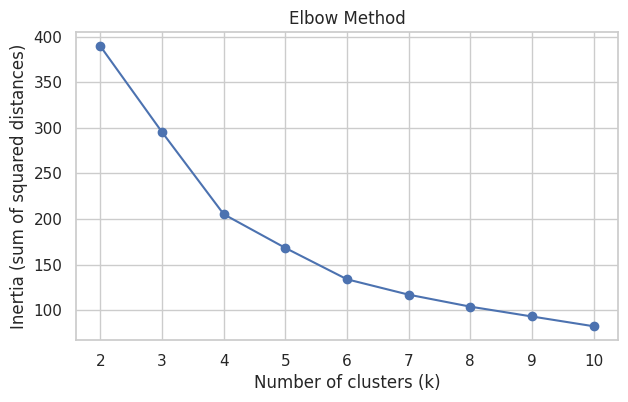

In [7]:
# Elbow Method (Inertia vs k)
inertias = []
k_values = range(2, 11)  # try k = 2 to 10

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(k_values, inertias, marker='o')
plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow Method")
plt.grid(True)
plt.savefig("elbow_plot.png", dpi=300, bbox_inches="tight")
plt.show()


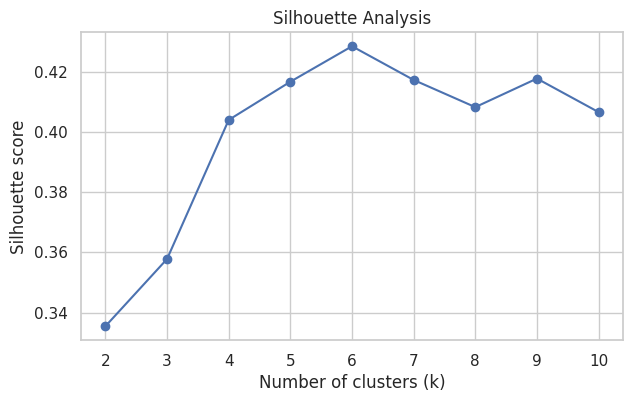

(6, np.float64(0.4284167762892593))

In [8]:
# Silhouette Score vs k
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(7,4))
plt.plot(k_values, sil_scores, marker='o')
plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis")
plt.grid(True)
plt.savefig("silhouette_plot.png", dpi=300, bbox_inches="tight")
plt.show()

best_k_by_silhouette = k_values[int(np.argmax(sil_scores))]
best_k_by_silhouette, max(sil_scores)


In [9]:
# Fit K-Means with the chosen k
# Choose k
k_opt = best_k_by_silhouette   # or set manually, e.g., k_opt = 5

kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clusters = df.copy()
df_clusters["Cluster"] = cluster_labels

df_clusters.head(), df_clusters["Cluster"].value_counts().sort_index()


(   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
 0    Male   19                  15                      39        4
 1    Male   21                  15                      81        4
 2  Female   20                  16                       6        5
 3  Female   23                  16                      77        4
 4  Female   31                  17                      40        5,
 Cluster
 0    45
 1    39
 2    33
 3    39
 4    23
 5    21
 Name: count, dtype: int64)

In [10]:
# Cluster profile (means per cluster)
profile = df_clusters.groupby("Cluster")[feature_cols].mean().round(2)
count = df_clusters["Cluster"].value_counts().sort_index()
summary = profile.copy()
summary["Count"] = count
summary


,Age,Annual Income (k$),Spending Score (1-100),Count
Cluster,,,,
0,56.33,54.27,49.07,45
1,26.79,57.10,48.13,39
2,41.94,88.94,16.97,33
3,32.69,86.54,82.13,39
4,25.00,25.26,77.61,23
5,45.52,26.29,19.38,21


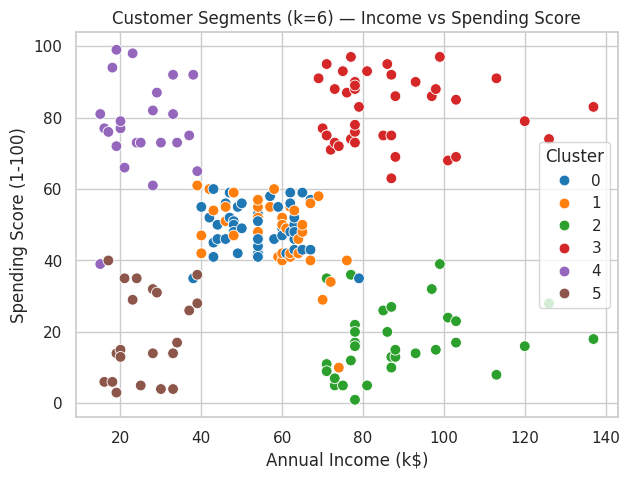

In [11]:
# 2D Visualization (Income vs Spending)
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_clusters,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster",
    palette="tab10",
    s=60,
    edgecolor="white"
)
plt.title(f"Customer Segments (k={k_opt}) — Income vs Spending Score")
plt.legend(title="Cluster")
plt.savefig("clusters_income_spending.png", dpi=300, bbox_inches="tight")
plt.show()


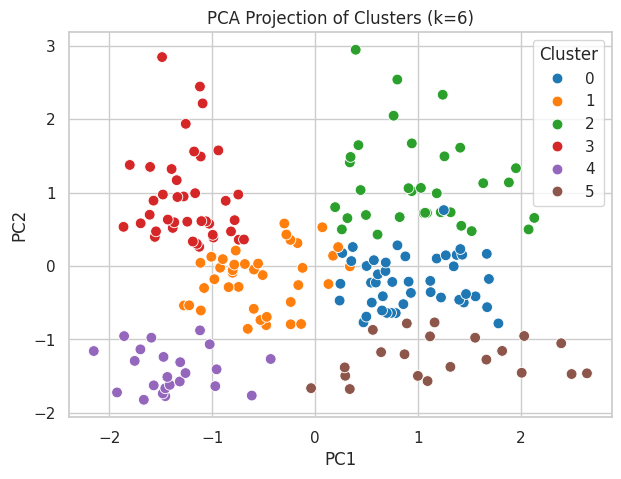

In [12]:
# 2D PCA visualization (if using 3+ features)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = cluster_labels

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    hue="Cluster", palette="tab10",
    s=60, edgecolor="white"
)
plt.title(f"PCA Projection of Clusters (k={k_opt})")
plt.legend(title="Cluster")
plt.savefig("clusters_pca.png", dpi=300, bbox_inches="tight")
plt.show()


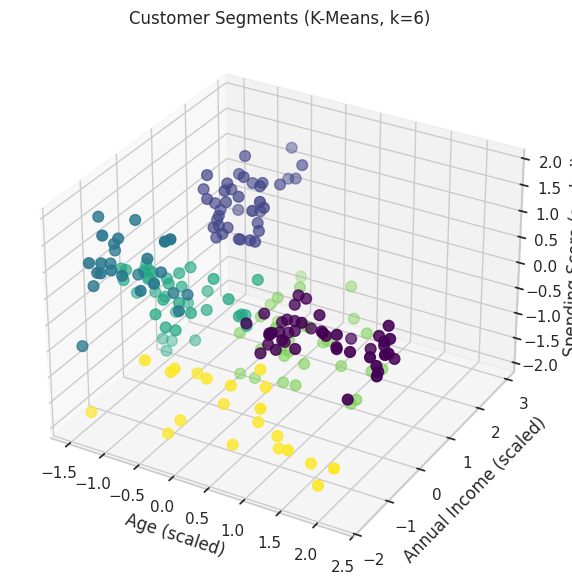

In [15]:
# 3D Cluster Visualization
from mpl_toolkits.mplot3d import Axes3D

# Features for 3D plot
X_3d = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].copy()
X_3d = StandardScaler().fit_transform(X_3d)

# Train KMeans again with optimal K
optimal_k = 6   # <-- Elbow/Silhouette se best aya
kmeans_3d = KMeans(n_clusters=optimal_k, random_state=42)
clusters_3d = kmeans_3d.fit_predict(X_3d)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
           c=clusters_3d, cmap='viridis', s=60)

ax.set_xlabel("Age (scaled)")
ax.set_ylabel("Annual Income (scaled)")
ax.set_zlabel("Spending Score (scaled)")
ax.set_title("Customer Segments (K-Means, k=6)")

plt.show()
